# CR6 Results Analysis

## Python Imports

In [24]:
import numpy as np
import pandas as pd
from prettypandas import PrettyPandas
import patsy
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api
from pyomo.environ import *

from IPython.display import display, Markdown, HTML

%matplotlib inline
PlotWidth = 6

import warnings
#warnings.filterwarnings('ignore')

## Install R Packages

In [2]:
# Using R inside python
import rpy2
import rpy2.robjects as ro
import rpy2.robjects.packages as rpackages

# Allow conversion
import rpy2.robjects as ro

from rpy2.robjects.vectors import StrVector
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri

from rpy2.robjects.conversion import localconverter

utils = rpackages.importr('utils')
utils.chooseCRANmirror(ind=1)

# Install packages
packnames = ('rsm')
#utils.install_packages(StrVector(packnames))

# Load packages
rsm = importr('rsm')
base = importr('base')

In [3]:
# helper functions for this notebook

# use SVG for matplotlib-based figures
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

def coded_to_actual(coded_data, actual_lows, actual_highs):
    """Converts a pandas DataFrame from coded units to actuals."""
    actual_data = coded_data.copy()
    for col in actual_data.columns:
        if not (col in actual_highs and col in actual_lows):
            continue
        try:
            # convert continuous variables to their actual value
            actual_data[col] *= 0.5 * (float(actual_highs[col]) - float(actual_lows[col]))
            # don't need to cast to float here, if either are not a float exception will have been thrown
            actual_data[col] += 0.5 * (actual_highs[col] + actual_lows[col])
        except ValueError:
            # assume 2 level categorical
            actual_data[col] = actual_data[col].map({-1: actual_lows[col], 1: actual_highs[col]})
    return actual_data
        
def get_tick_labels(key, lows, highs, units):
    """Returns a list of low/high labels with units (e.g. [8mm, 10mm])"""
    return [str(lows[key]) + units[key], str(highs[key]) + units[key]]

## Process CSV Files

In [4]:

# importing the pandas library
import pandas as pd
  
# reading the csv file using read_csv
# storing the data frame in variable called df
df_cost = pd.read_csv('https://raw.githubusercontent.com/wilsongis/3DP_Experiments/main/Data/cr6_cost.txt', sep='\t')
df_time = pd.read_csv('https://raw.githubusercontent.com/wilsongis/3DP_Experiments/main/Data/cr6_time.txt', sep='\t')
  
# creating a list of column names by
# calling the .columns
list_of_columns_cost = list(df_cost.columns)
list_of_columns_time = list(df_time.columns)
  
# displaying the list of column names
print('List of Cost column names : ', 
      list_of_columns_cost)
print('List of Time column names : ', 
      list_of_columns_time)

List of Cost column names :  ['trial', 'lh', 'ps', 'id', 'rw', 'wt', 'alh', 'aps', 'aid', 'arw', 'awt', 'rep', 'cost']
List of Time column names :  ['trial', 'lh', 'ps', 'id', 'rw', 'wt', 'alh', 'aps', 'aid', 'arw', 'awt', 'rep', 'time']


In [5]:
display((Markdown("### Statistics for Cost")))
df_cost.cost.describe()

### Statistics for Cost

count    80.000000
mean      0.531500
std       0.019623
min       0.480000
25%       0.510000
50%       0.540000
75%       0.540000
max       0.560000
Name: cost, dtype: float64

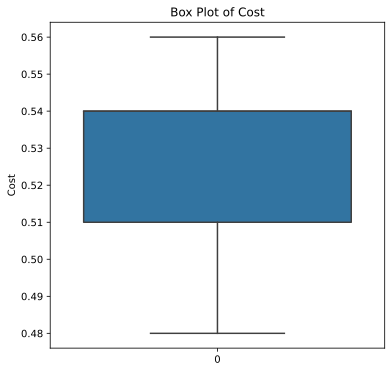

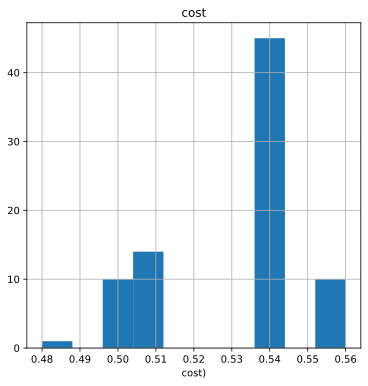

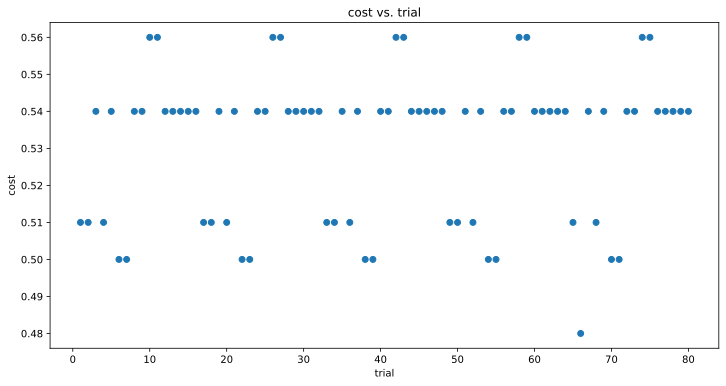

In [6]:
plt.figure(figsize=(PlotWidth, PlotWidth))
sns.boxplot(data=df_cost['cost'])
plt.title('Box Plot of Cost')
plt.ylabel('Cost')
plt.show()

plt.figure(figsize=(PlotWidth, PlotWidth))
df_cost['cost'].hist()
plt.title('cost')
plt.xlabel('cost)')
plt.show()

plt.figure(figsize=(PlotWidth*2, PlotWidth))
plt.scatter(df_cost['trial'], df_cost['cost'])
plt.title('cost vs. trial')
plt.xlabel('trial')
plt.ylabel('cost')
plt.show()

In [7]:
display((Markdown("### Statistics for Time")))
df_time.time.describe()

### Statistics for Time

count       80.000000
mean     12731.137500
std       3377.982889
min       8480.000000
25%       9464.250000
50%      13333.000000
75%      15460.750000
max      18098.000000
Name: time, dtype: float64

plt.figure(figsize=(PlotWidth, PlotWidth))
sns.boxplot(data=df_time['time'])
plt.title('Box Plot of Time')
plt.ylabel('Time')
plt.show()

plt.figure(figsize=(PlotWidth, PlotWidth))
df_time['time'].hist()
plt.title('time')
plt.xlabel('time)')
plt.show()

plt.figure(figsize=(PlotWidth*2, PlotWidth))
plt.scatter(df_time['trial'], df_time['time'])
plt.title('time vs. trial')
plt.xlabel('trial')
plt.ylabel('time')
plt.show()

# Cost Analysis

In [8]:
display(Markdown("## Cost Ordinary Least Squares Regression - Coded"))
lm_cost_coded = statsmodels.formula.api.ols("cost ~ (lh+ps+id+rw+wt)**2", data=df_cost).fit()
print(lm_cost_coded.summary2())

display(Markdown("## Cost Ordinary Least Squares Regression - Actual"))
lm_cost_actual = statsmodels.formula.api.ols("cost ~ (alh+aps+aid+arw+awt)**2", data=df_cost).fit()
print(lm_cost_actual.summary2())


## Cost Ordinary Least Squares Regression - Coded

                  Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.971     
Dependent Variable: cost             AIC:                -670.4327 
Date:               2021-07-05 18:20 BIC:                -632.3203 
No. Observations:   80               Log-Likelihood:     351.22    
Df Model:           15               F-statistic:        176.0     
Df Residuals:       64               Prob (F-statistic): 5.35e-46  
R-squared:          0.976            Scale:              1.1250e-05
--------------------------------------------------------------------
               Coef.   Std.Err.      t      P>|t|    [0.025   0.975]
--------------------------------------------------------------------
Intercept      0.5315    0.0004  1417.3333  0.0000   0.5308   0.5322
lh            -0.0023    0.0004    -6.0000  0.0000  -0.0030  -0.0015
ps             0.0023    0.0004     6.0000  0.0000   0.0015   0.0030
id            -0.0015    0.0004    -4.0000  0.0002  -0.0022 

## Cost Ordinary Least Squares Regression - Actual

                  Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.971     
Dependent Variable: cost             AIC:                -670.4327 
Date:               2021-07-05 18:20 BIC:                -632.3203 
No. Observations:   80               Log-Likelihood:     351.22    
Df Model:           15               F-statistic:        176.0     
Df Residuals:       64               Prob (F-statistic): 5.35e-46  
R-squared:          0.976            Scale:              1.1250e-05
--------------------------------------------------------------------
                Coef.   Std.Err.     t      P>|t|    [0.025   0.975]
--------------------------------------------------------------------
Intercept       0.3748    0.0362   10.3630  0.0000   0.3026   0.4471
alh             0.0042    0.0820    0.0508  0.9596  -0.1596   0.1679
aps            -0.0030    0.0006   -4.9550  0.0000  -0.0042  -0.0018
aid             0.0900    0.0976    0.9219  0.3601  -0.1050 

In [9]:
print(lm_cost_actual.params)

Intercept    0.374833
alh          0.004167
aps         -0.002983
aid          0.090000
arw          0.305000
awt          0.192500
alh:aps      0.003333
alh:aid     -0.750000
alh:arw      0.187500
alh:awt     -0.187500
aps:aid      0.009000
aps:arw     -0.002250
aps:awt      0.002250
aid:arw      0.350000
aid:awt     -0.600000
arw:awt     -0.225000
dtype: float64


In [10]:
cb = (str(lm_cost_actual.params[0]))
cv1 = (str(lm_cost_actual.params[1]))
cv2 = (str(lm_cost_actual.params[2]))
cv3 = (str(lm_cost_actual.params[3]))
cv4 = (str(lm_cost_actual.params[4]))
cv5 = (str(lm_cost_actual.params[5]))
cv6 = (str(lm_cost_actual.params[6]))
cv7 = (str(lm_cost_actual.params[7]))
cv8 = (str(lm_cost_actual.params[8]))
cv9 = (str(lm_cost_actual.params[9]))
cv10 = (str(lm_cost_actual.params[10]))
cv11 = (str(lm_cost_actual.params[11]))
cv12 = (str(lm_cost_actual.params[12]))
cv13 = (str(lm_cost_actual.params[13]))
cv14 = (str(lm_cost_actual.params[14]))
cv15 = (str(lm_cost_actual.params[15]))

In [29]:
eq_cost_actual = (
    cb + " + " + cv1 + "*model.X1" + " + " + cv2 + "*model.X2" +  " + " + cv3 + "*model.X3" + " + " + cv4 + "*model.X4" + " + " + cv5 + "*model.X5" + " + " 
    + cv6 + "*model.X1*model.X2" + " + " + cv7 + "*model.X1*model.X3" + " + " + cv8 + "*model.X1*model.X4" + " + " + cv9 + "*model.X1*model.X5" + " + " + cv10 
    + "*model.X2*model.X3" + " + " + cv11 + "*model.X2*model.X4" + " + " + cv12 + "*model.X2*model.X5" + " + " + cv13 
    + "*model.X3*model.X4" + " + " + cv14 + "*model.X3*model.X5" + " + " + cv15 + "*model.X4*model.X5")


In [30]:
print(eq_cost_actual)

0.3748333333333349 + 0.004166666666655772*model.X1 + -0.0029833333333334766*model.X2 + 0.08999999999998987*model.X3 + 0.30500000000000094*model.X4 + 0.192500000000001*model.X5 + 0.0033333333333336324*model.X1*model.X2 + -0.7499999999999938*model.X1*model.X3 + 0.18750000000000377*model.X1*model.X4 + -0.18750000000000078*model.X1*model.X5 + 0.009000000000000938*model.X2*model.X3 + -0.0022499999999998355*model.X2*model.X4 + 0.0022499999999998385*model.X2*model.X5 + 0.3500000000000012*model.X3*model.X4 + -0.5999999999999952*model.X3*model.X5 + -0.22499999999999876*model.X4*model.X5


# Time Analysis

In [13]:
display(Markdown("## Time Ordinary Least Squares Regression - Coded"))
lm_time_coded = statsmodels.formula.api.ols("time ~ (lh+ps+id+rw+wt)**2", data=df_time).fit()
print(lm_time_coded.summary2())

display(Markdown("## Time Ordinary Least Squares Regression - Actual"))
lm_time_actual = statsmodels.formula.api.ols("time ~ (alh+aps+aid+arw+awt)**2", data=df_time).fit()
print(lm_time_actual.summary2())

## Time Ordinary Least Squares Regression - Coded

                  Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.982     
Dependent Variable: time             AIC:                1221.4203 
Date:               2021-07-05 18:20 BIC:                1259.5328 
No. Observations:   80               Log-Likelihood:     -594.71   
Df Model:           15               F-statistic:        282.4     
Df Residuals:       64               Prob (F-statistic): 2.02e-52  
R-squared:          0.985            Scale:              2.0961e+05
-------------------------------------------------------------------
            Coef.    Std.Err.    t     P>|t|    [0.025     0.975]  
-------------------------------------------------------------------
Intercept 12731.1375  51.1876 248.7153 0.0000 12628.8785 12833.3965
lh        -2015.2125  51.1876 -39.3692 0.0000 -2117.4715 -1912.9535
ps         -329.7875  51.1876  -6.4427 0.0000  -432.0465  -227.5285
id          -70.7125  51.1876  -1.3814 0.1719  -172.9715    31.546

## Time Ordinary Least Squares Regression - Actual

                      Results: Ordinary least squares
Model:                  OLS                Adj. R-squared:       0.982     
Dependent Variable:     time               AIC:                  1221.4203 
Date:                   2021-07-05 18:20   BIC:                  1259.5328 
No. Observations:       80                 Log-Likelihood:       -594.71   
Df Model:               15                 F-statistic:          282.4     
Df Residuals:           64                 Prob (F-statistic):   2.02e-52  
R-squared:              0.985              Scale:                2.0961e+05
---------------------------------------------------------------------------
             Coef.      Std.Err.     t     P>|t|     [0.025       0.975]   
---------------------------------------------------------------------------
Intercept  -72680.1375  4937.2659 -14.7207 0.0000  -82543.4600  -62816.8150
alh        128705.0000 11188.6478  11.5032 0.0000  106353.1064  151056.8936
aps          1898.0067    82.1840 

## Time Reduced Model

In [14]:
display(Markdown("## Time Ordinary Least Squares Regression - Actual"))
lm_time_actual_reduced = statsmodels.formula.api.ols("time ~ (alh+aps+aid+arw+awt+alh:aps+alh:aid+alh:arw+alh:awt+aps:awt+aid:awt+arw:awt )", data=df_time).fit()
print(lm_time_actual_reduced.summary2())

## Time Ordinary Least Squares Regression - Actual

                      Results: Ordinary least squares
Model:                  OLS                Adj. R-squared:       0.982     
Dependent Variable:     time               AIC:                  1219.3180 
Date:                   2021-07-05 18:20   BIC:                  1250.2843 
No. Observations:       80                 Log-Likelihood:       -596.66   
Df Model:               12                 F-statistic:          351.8     
Df Residuals:           67                 Prob (F-statistic):   1.55e-55  
R-squared:              0.984              Scale:                2.1022e+05
---------------------------------------------------------------------------
             Coef.      Std.Err.     t     P>|t|     [0.025       0.975]   
---------------------------------------------------------------------------
Intercept  -71031.5500  4014.9894 -17.6916 0.0000  -79045.5024  -63017.5976
alh        128705.0000 11204.9457  11.4864 0.0000  106339.8348  151070.1652
aps          1866.1642    64.3902 

In [15]:
print(lm_time_actual_reduced.params)

Intercept    -71031.550000
alh          128705.000000
aps            1866.164167
aid         -172720.583333
arw           45471.062500
awt           53415.750000
alh:aps       -3696.291667
alh:aid      349970.833333
alh:arw      -89884.375000
alh:awt       24940.625000
aps:awt       -1118.937500
aid:awt       97141.250000
arw:awt      -25880.312500
dtype: float64


In [16]:
tb = (str(lm_time_actual_reduced.params[0]))
tv1 = (str(lm_time_actual_reduced.params[1]))
tv2 = (str(lm_time_actual_reduced.params[2]))
tv3 = (str(lm_time_actual_reduced.params[3]))
tv4 = (str(lm_time_actual_reduced.params[4]))
tv5 = (str(lm_time_actual_reduced.params[5]))
tv6 = (str(lm_time_actual_reduced.params[6]))
tv7 = (str(lm_time_actual_reduced.params[7]))
tv8 = (str(lm_time_actual_reduced.params[8]))
tv9 = (str(lm_time_actual_reduced.params[9]))
tv10 = (str(lm_time_actual_reduced.params[10]))
tv11 = (str(lm_time_actual_reduced.params[11]))
tv12 = (str(lm_time_actual_reduced.params[12]))


In [21]:
eq_time_actual = (
    tb + " + " + tv1 + "*model.X1" + " + " + tv2 + "*model.X2" +  " + " + tv3 + "*model.X3" + " + " + tv4 + "*model.X4" + " + " + 
    tv5 + "*model.X5" + " + " + tv6 + "*model.X1*model.X2" + " + " + tv7 + "*model.X1*model.X3" + " + " + tv8 + "*model.X1*model.X4" + 
    " + " + tv9 + "*model.X1*model.X5" + " + " + tv10 + "*model.X2*model.X5" + " + " + tv11 + "*model.X3*model.X5" + " + " + tv12  + 
    "*model.X4*model.X5") 

## Equations

In [31]:
display(Markdown("Cost = "))
print(eq_cost_actual)

print("------")

display(Markdown("Time = "))
print(eq_time_actual)


Cost = 

0.3748333333333349 + 0.004166666666655772*model.X1 + -0.0029833333333334766*model.X2 + 0.08999999999998987*model.X3 + 0.30500000000000094*model.X4 + 0.192500000000001*model.X5 + 0.0033333333333336324*model.X1*model.X2 + -0.7499999999999938*model.X1*model.X3 + 0.18750000000000377*model.X1*model.X4 + -0.18750000000000078*model.X1*model.X5 + 0.009000000000000938*model.X2*model.X3 + -0.0022499999999998355*model.X2*model.X4 + 0.0022499999999998385*model.X2*model.X5 + 0.3500000000000012*model.X3*model.X4 + -0.5999999999999952*model.X3*model.X5 + -0.22499999999999876*model.X4*model.X5
------


Time = 

-71031.55000000093 + 128704.99999999983*model.X1 + 1866.1641666666828*model.X2 + -172720.583333333*model.X3 + 45471.062500000015*model.X4 + 53415.75000000034*model.X5 + -3696.291666666646*model.X1*model.X2 + 349970.83333333314*model.X1*model.X3 + -89884.37500000007*model.X1*model.X4 + 24940.62500000026*model.X1*model.X5 + -1118.9374999999773*model.X2*model.X5 + 97141.2499999996*model.X3*model.X5 + -25880.31249999999*model.X4*model.X5


# Optimization

In [33]:
model = ConcreteModel()

model.X1 = Var(within=NonNegativeReals)
model.X2 = Var(within=NonNegativeReals)
model.X3 = Var(within=NonNegativeReals)
model.X4 = Var(within=NonNegativeReals)
model.X5 = Var(within=NonNegativeReals)

model.C1 = Constraint(expr = model.X1 <= .28)
model.C2 = Constraint(expr = model.X2 <= 60)
model.C3 = Constraint(expr = model.X3 <= .25)
model.C4 = Constraint(expr = model.X4 <= .8)
model.C5 = Constraint(expr = model.X5 <= 1.2)

model.C6 = Constraint(expr = model.X1 >= .16)
model.C7 = Constraint(expr = model.X2 >= 50)
model.C8 = Constraint(expr = model.X3 >= .15)
model.C9 = Constraint(expr = model.X4 >= .4)
model.C10 = Constraint(expr = model.X5 >= .8)

model.f1 = Var()
model.f2 = Var()
model.C_f1 = Constraint(expr = model.f1 == (0.3748333333333349 + 0.004166666666655772*model.X1 + 
                                            -0.0029833333333334766*model.X2 + 0.08999999999998987*model.X3 + 
                                            0.30500000000000094*model.X4 + 0.192500000000001*model.X5 +
                                            0.0033333333333336324*model.X1*model.X2 + -0.7499999999999938*model.X1*model.X3 
                                            + 0.18750000000000377*model.X1*model.X4 + -0.18750000000000078*model.X1*model.X5 
                                            + 0.009000000000000938*model.X2*model.X3 
                                            + -0.0022499999999998355*model.X2*model.X4 
                                            + 0.0022499999999998385*model.X2*model.X5 + 0.3500000000000012*model.X3*model.X4 
                                            + -0.5999999999999952*model.X3*model.X5 + -0.22499999999999876*model.X4*model.X5))
model.C_f2 = Constraint(expr = model.f2 == (-71031.55000000093 + 128704.99999999983*model.X1 + 
                                            1866.1641666666828*model.X2 + -172720.583333333*model.X3 + 
                                            45471.062500000015*model.X4 + 53415.75000000034*model.X5 
                                            + -3696.291666666646*model.X1*model.X2 + 349970.83333333314*model.X1*model.X3 
                                            + -89884.37500000007*model.X1*model.X4 + 24940.62500000026*model.X1*model.X5 
                                            + -1118.9374999999773*model.X2*model.X5 + 97141.2499999996*model.X3*model.X5 
                                            + -25880.31249999999*model.X4*model.X5))
model.O_f1 = Objective(expr = model.f1, sense=minimize)
model.O_f2 = Objective(expr = model.f2, sense=minimize)

# max f1 separately
# install glpk solver:  sudo apt-get install glpk-utils
model.O_f2.deactivate()
solver = SolverFactory('ipopt')  #'cplex', 'ipopt'
solver.solve(model)

print('( X1 , X2, X3, X4, X5 ) = ( ' + str(value(model.X1)) + ' , ' + str(value(model.X2)) + ' , ' + str(value(model.X3)) + ' , ' + str(value(model.X4)) + ' , ' + str(value(model.X5)) + ' )')
print('f1 = ' + str(value(model.f1)))
print('f2 = ' + str(value(model.f2)))
f2_min = value(model.f2)

# max f2 separately
model.O_f2.activate()
model.O_f1.deactivate()
solver = SolverFactory('ipopt')  #'cplex', 'ipopt'
solver.solve(model)

print('( X1 , X2, X3, X4, X5 ) = ( ' + str(value(model.X1)) + ' , ' + str(value(model.X2)) + ' , ' + str(value(model.X3)) + ' , ' + str(value(model.X4)) + ' , ' + str(value(model.X5)) + ' )')
print('f1 = ' + str(value(model.f1)))
print('f2 = ' + str(value(model.f2)))
f2_max = value(model.f2)

# apply augmented $\epsilon$-Constraint
# max   		f1 + delta*s
# constraint 	f2 - s = e
model.O_f1.activate()
model.O_f2.deactivate()

model.del_component(model.O_f1)
model.del_component(model.O_f2)

model.e = Param(initialize=0, mutable=True)
model.delta = Param(initialize=0.00001)
model.slack = Var(within=NonNegativeReals)
model.O_f1 = Objective(expr = model.f1 + model.delta * model.slack, sense=maximize)
model.C_e = Constraint(expr = model.f2 - model.slack == model.e)

n = 100
step = int((f2_max - f2_min) / n)
steps = list(range(int(f2_min),int(f2_max),step)) + [f2_max]

x1_l, x2_l, x3_l, x4_l, x5_l = [], [], [], [], []
f1_l, f2_l = [], []
for i in steps:
    model.e = i
    solver.solve(model)
    x1_l.append(value(model.X1))
    x2_l.append(value(model.X2))
    x3_l.append(value(model.X3))
    x4_l.append(value(model.X4))
    x5_l.append(value(model.X5))
    f1_l.append(value(model.f1))
    f2_l.append(value(model.f2))
    # print(i, value(model.X1), value(model.X2), value(model.f1), value(model.slack), value(model.f2))



( X1 , X2, X3, X4, X5 ) = ( 0.2799999826626221 , 50.00000177811698 , 0.24999975927998574 , 0.400000006432218 , 0.8000001905772277 )
f1 = 0.4990000093142275
f2 = 10713.514902721863
( X1 , X2, X3, X4, X5 ) = ( 0.1599999900001609 , 49.999999500006574 , 0.25000000999993593 , 0.3999999900002399 , 0.7999999900001623 )
f1 = 0.5099999997166924
f2 = 8867.686508489907
